# run_car

In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ioff()
dyn_plot = True
class DynamicUpdate():
    def on_launch(self):
        #Set up plot
        self.figure, self.ax = plt.subplots()
        self.lines, = self.ax.plot([],[])
        #Autoscale on unknown axis and known lims on the other
        self.ax.set_autoscaley_on(True)
        self.ax.set_autoscalex_on(True)
        #Other stuff
        self.ax.grid()

    def on_running(self, xdata, ydata):
        #Update data (with the new _and_ the old points)
        self.lines.set_xdata(xdata)
        self.lines.set_ydata(ydata)
        #Need both of these in order to rescale
        self.ax.relim()
        self.ax.autoscale_view()
        #We need to draw *and* flush
        self.figure.canvas.draw()
        self.figure.canvas.flush_events()

In [2]:
import datetime
import numpy as np
import random

In [3]:
from cars.world import SimpleCarWorld
from cars.agent import SimpleCarAgent
from cars.physics import SimplePhysics
from cars.track import generate_map

In [4]:
from tqdm import tqdm_notebook

In [5]:
from functools import reduce

In [6]:
import pandas as pd

In [7]:
def create_map(seed, agent):
    np.random.seed(seed)
    random.seed(seed)
    m = generate_map(8, 5, 3, 3)
    w = SimpleCarWorld([agent], m, SimplePhysics, None, timedelta=0.2)
    return w

In [8]:
import seaborn as sns

# Параметры

In [9]:
map_seeds = [3, 13, 23]

In [10]:
# За сколько шагов модель начинает учитывать вознаграждение
map_seed = map_seeds[0]

# Нарабатываем данные, учимся и оцениваемся

In [12]:
def norm_y(y):
    return y / 15.0

In [13]:
def mine_data(agent, agent_random_action,
              clear_history, map_seed, steps,
              epochs, mini_batch_size, eta, reward_shift, alpha):
    agent.RANDOM_ACTION_P = agent_random_action
    if clear_history:
        agent.clear_history()
    
    #mine data
    w = create_map(seed=map_seed, agent=agent)
    w.run(steps=tqdm_notebook(range(steps), desc="train", leave=False), visual=False, save=False)

    # prepare train data
    X_train = np.concatenate([agent.sensor_data_history, agent.chosen_actions_history], axis=1)
    y_train = np.array(agent.reward_history)
    # сглаживаем пики, чтобы сеть небольшая сеть могла дать адекватное предсказание
    mean_train_revard = y_train.mean()
    y_train = norm_y(y_train)
    
    y_train = np.pad(y_train, (0, reward_shift + 1), mode="constant")
    y_train = reduce(lambda a, b: a + b, [y_train[i:(i - reward_shift - 1)] * (alpha ** (i - 1))
                                          for i in range(1, reward_shift+1)])

    #train NN
    train_data = [(x[:, np.newaxis], y) for x, y in zip(X_train, y_train)]
    agent.neural_net.SGD(training_data=train_data,
                         epochs=epochs,
                         mini_batch_size=mini_batch_size,
                         eta=eta)
    train_rmse = agent.neural_net.evaluate(X_train.T, y_train)

    # evaluate
    w = create_map(seed=map_seed, agent=agent)
    mean_test_reward = w.evaluate_agent(agent, steps=tqdm_notebook(range(800), desc="test", leave=False), visual=False)
    log_message = f"""map_seed = {map_seed}
agent_random_action = {agent_random_action:.2f}
train_rmse = {train_rmse:.9f}
mean_train_revard = {mean_train_revard:.3f}
mean_test_reward  = {mean_test_reward:.3f}"""

    if dyn_plot:
        chart_count = agent.neural_net.num_layers
        plt.figure(figsize=(5 * chart_count, 2))
        for l in range(chart_count - 1):
            plt.subplot(1, chart_count, l+1)
            ax = sns.heatmap(agent.neural_net.weights[l])

        plt.subplot(1, chart_count, chart_count)    
        plt.text(0.05, 0.95, log_message, size=12, ha='left', va='top', family='monospace')

        plt.show()
    else:
        print(log_message)

440/|/ 22%|| 440/2000 [00:19<01:10, 22.03it/s]                                                                         

<IPython.core.display.Javascript object>


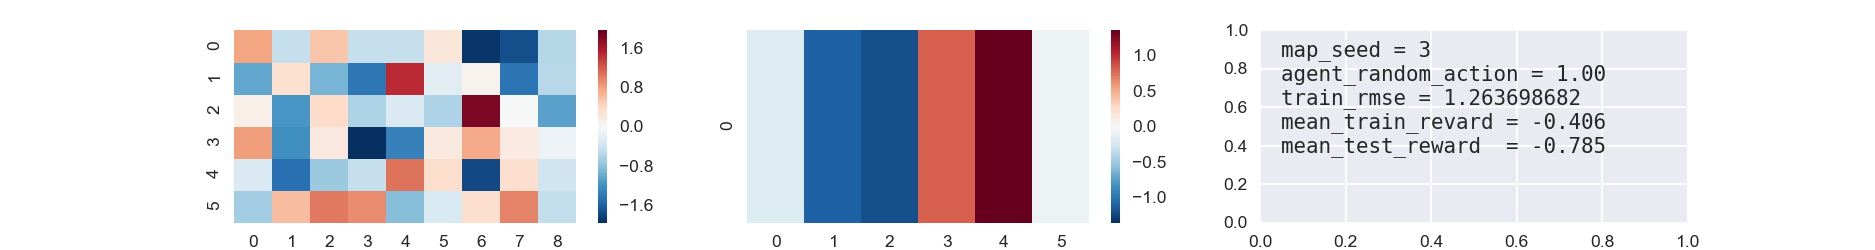

<IPython.core.display.Javascript object>


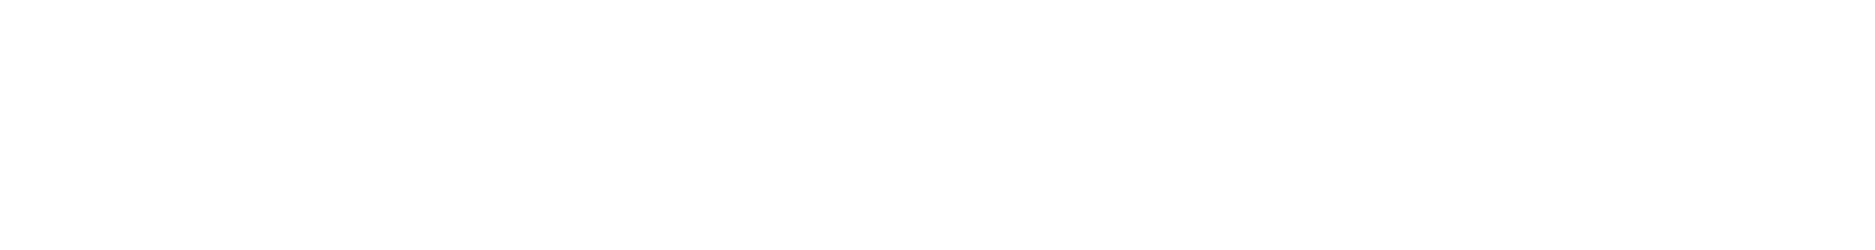

<IPython.core.display.Javascript object>


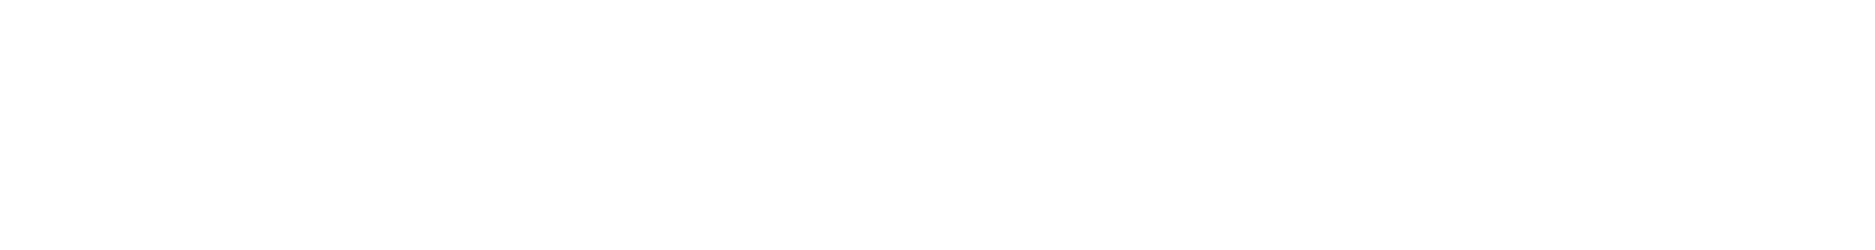

<IPython.core.display.Javascript object>


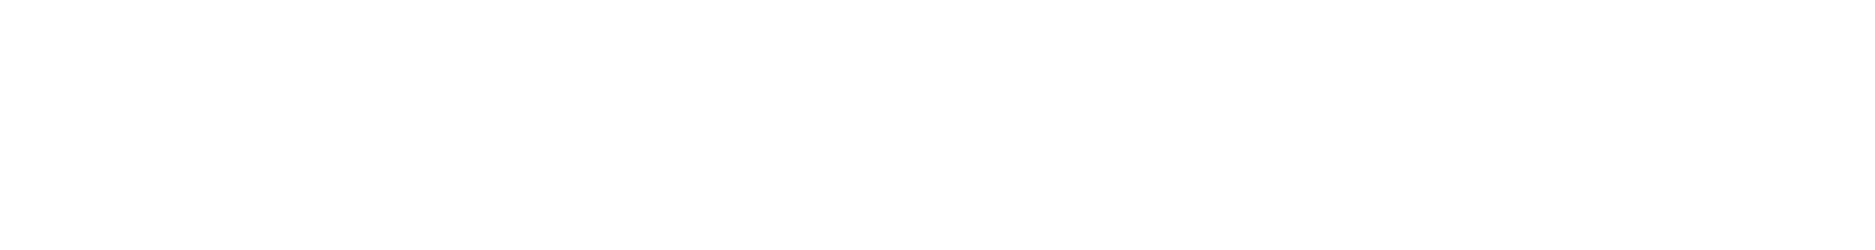

<IPython.core.display.Javascript object>


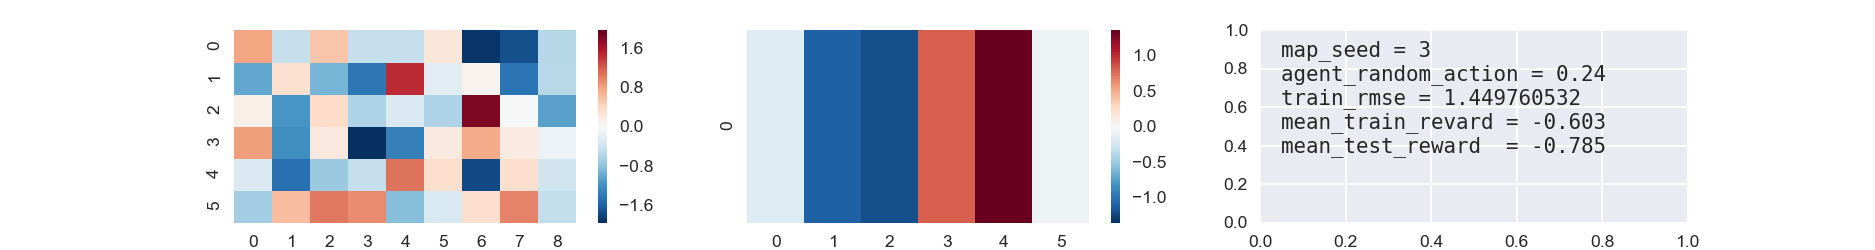

<IPython.core.display.Javascript object>


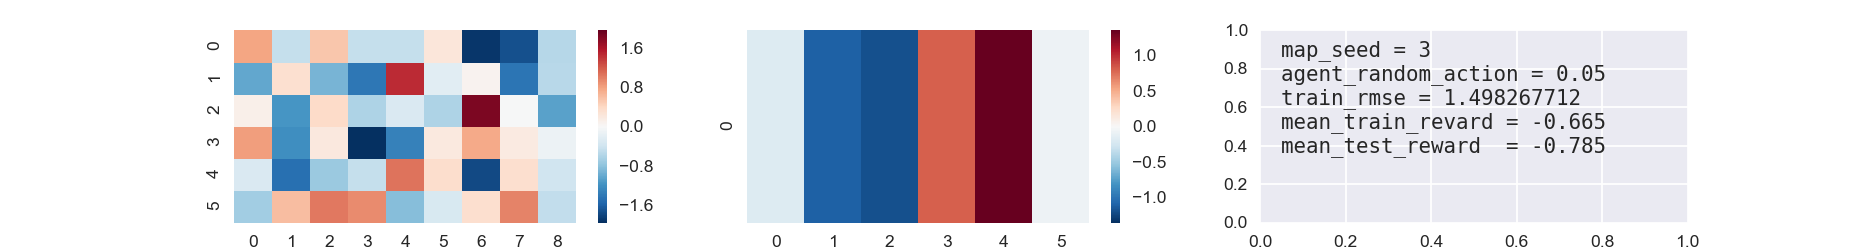

In [15]:
kvparams = {
    "clear_history": False,
    "map_seed": map_seed,
    "epochs": 40,
    "mini_batch_size": 100,
    "eta": 0.05,
    "reward_shift": 6,
    "alpha": 0.8
}

random.seed(42)
np.random.seed(42)
agent1 = SimpleCarAgent(name="Ivan", history_data=10000)

for agent_random_action in tqdm_notebook(np.arange(1, 0, -.19), desc="main_1"):
    mine_data(agent1, agent_random_action, steps=2000, **kvparams)

In [ ]:
for _ in tqdm_notebook(range(5), desc="main_2"):
    mine_data(agent1, agent_random_action=0.05, steps=10000, **kvparams)

На первом слое: скорость, направление, лидары, руль, ускорение 

# Смотрим вживую

In [59]:
def visualize(agent, map_seed):
    agent.evaluate_mode=True
    print("visualize on map = {}".format(map_seed))
    agent.clear_history()
    w = create_map(seed=map_seed, agent=agent)
    w.run(steps=None, visual=True, save=False)

In [61]:
visualize(agent1, map_seed)

visualize on map = 3


# Отладка

In [ ]:
raise Exception("Здесь отладка")

In [16]:
agent_dbg = agent1

In [64]:
agent_dbg.clear_history()
#mine data
w = create_map(seed=map_seed, agent=agent_dbg)
w.run(steps=tqdm_notebook(range(10000), desc="train", leave=False), visual=False, save=False)

AssertionError: Something went wrong: CarState(position=(5.027307085756307-5.7275863816001795j), velocity=(-7.27763398163511e-14-6.562328278751167e-15j), heading=(-0.995959204017509-0.08980681451209563j)), Action(steering=1.0, acceleration=0.0)

In [65]:
# prepare train data
X_train = np.concatenate([agent_dbg.sensor_data_history, agent_dbg.chosen_actions_history], axis=1)
y_train = np.array(agent_dbg.reward_history)
y_train = norm_y(y_train)
y_clean = y_train.copy()
mean_train_revard = y_train.mean()
mean_train_revard

-0.26398129768142575

In [66]:
reward_shift = 6
alpha = 0.8

In [67]:
y_train = np.pad(y_train, (0, 2 * reward_shift), mode="constant")
y_train = reduce(lambda a, b: a + b, [y_train[i:(-2 * reward_shift + i)] * (alpha ** (i - 1))
                                      for i in range(1, reward_shift+1)])

In [68]:
y_predict = agent_dbg.neural_net.feedforward(X_train.T)

In [69]:
pd_visual = pd.DataFrame(X_train,
                         columns=["velocity", "angle"] +
                         ["lid{}".format(i) for i in range(agent_dbg.rays)] +
                         ["steering", "acceleration"])
pd_visual["y_clean"] = y_clean
pd_visual["y_train"] = y_train
pd_visual["y_predict"] = y_predict.flatten()

In [70]:
pd_visual.head(15)

,velocity,angle,lid0,lid1,lid2,lid3,lid4,steering,acceleration,y_clean,y_train,y_predict
0,0.000000,-0.171753,9.810891,1.998454,1.317369,1.148346,2.116700,1.0,0.00,-0.213333,-0.787046,-0.008049
1,0.000000,-0.171753,9.810891,1.998454,1.317369,1.148346,2.116700,1.0,0.00,-0.213333,-0.717141,-0.008049
2,0.000000,-0.171753,9.810891,1.998454,1.317369,1.148346,2.116700,1.0,0.00,-0.213333,-0.629760,-0.008049
3,0.000000,-0.171753,9.810891,1.998454,1.317369,1.148346,2.116700,1.0,0.00,-0.213333,-0.520533,-0.008049
4,0.000000,-0.171753,9.810891,1.998454,1.317369,1.148346,2.116700,1.0,0.00,-0.213333,-0.384000,-0.008049
5,0.000000,-0.171753,9.810891,1.998454,1.317369,1.148346,2.116700,1.0,0.00,-0.213333,-0.213333,-0.008049
6,0.000000,-0.171753,9.810891,1.998454,1.317369,1.148346,2.116700,1.0,-0.75,-0.213333,0.000000,-0.008095
7,0.045000,0.985018,1.450792,1.860662,9.806391,1.998117,1.320169,-1.0,-0.75,0.000000,0.000000,-0.006446
8,0.156605,0.357976,2.431114,4.974840,1.665842,1.169194,1.250529,1.0,-0.75,0.000000,0.000000,-0.007862
9,0.188279,0.563614,1.919365,9.798709,1.929540,1.294486,1.137603,1.0,-0.75,0.000000,0.000000,-0.007351


1165/|/ 12%|| 1165/10000 [00:23<02:58, 49.41it/s]                                                                      

In [ ]:
pd_visual[:2000].plot(y=["y_clean", "y_train", "y_predict"], figsize=(64, 6))

<IPython.core.display.Javascript object>

In [58]:
rmse_before = ((pd_visual.y_train - pd_visual.y_predict)**2).mean() ** 0.5
rmse_before

0.10757975463292212

In [26]:
train_data = [(x[:, np.newaxis], y) for x, y in zip(X_train, y_train)]

In [31]:
from learning_algorithms.network import Network

In [48]:
epoch_num = 1
dyp_x = []
dyp_y = []

agent_dbg.neural_net = Network([9, 12, 1], output_function=lambda x: x, output_derivative=lambda x: 1)

<IPython.core.display.Javascript object>


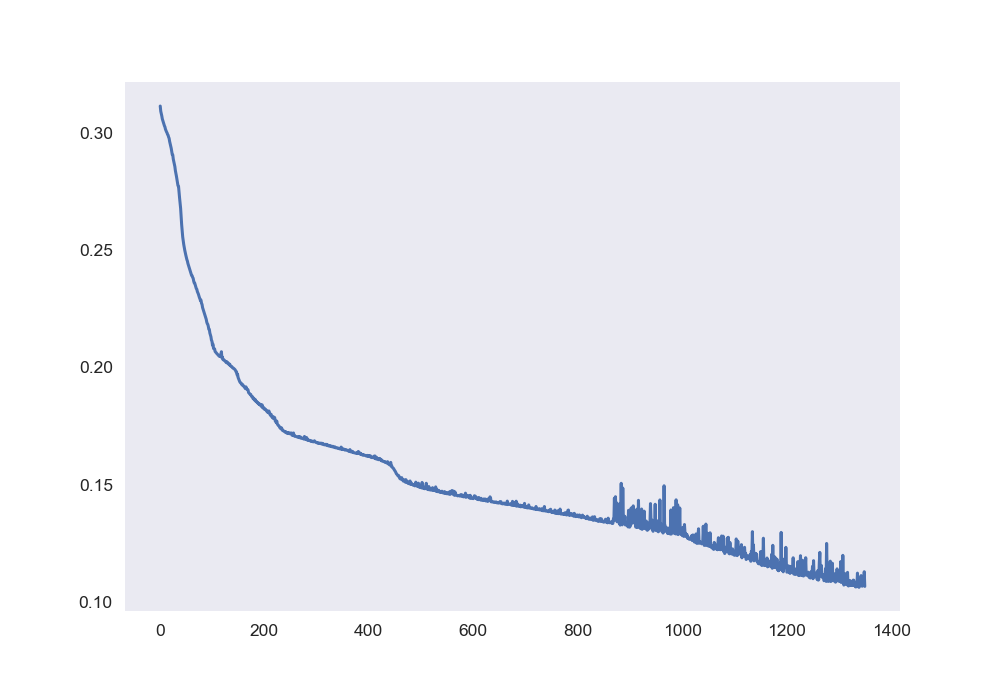

min rmse: 0.1061837493656046


In [52]:
plt.ion()
dyp = DynamicUpdate()
dyp.on_launch()

try:
    for res in agent_dbg.neural_net.SGD(
            training_data=train_data,
            epochs=2000,
            mini_batch_size=50,
            eta=0.8,
            test_data=(X_train.T, y_train)):
        dyp_x.append(epoch_num)
        epoch_num += 1
        dyp_y.append(res)
        if epoch_num % 10 == 0:
            dyp.on_running(dyp_x, dyp_y)
except KeyboardInterrupt:
    print("min rmse: {}".format(min(dyp_y)))

In [ ]:

              epochs, mini_batch_size, eta, reward_shift, alpha):

    




    # evaluate
    w = create_map(seed=map_seed, agent=agent)
    mean_test_reward = w.evaluate_agent(agent, steps=tqdm_notebook(range(800), desc="test", leave=False), visual=False)
    log_message = f"""map_seed = {map_seed}
agent_random_action = {agent_random_action:.2f}
train_rmse = {train_rmse:.9f}
mean_train_revard = {mean_train_revard:.3f}
mean_test_reward  = {mean_test_reward:.3f}"""

    chart_count = agent.neural_net.num_layers
    plt.figure(figsize=(5 * chart_count, 2))
    for l in range(chart_count - 1):
        plt.subplot(1, chart_count, l+1)
        ax = sns.heatmap(agent.neural_net.weights[l])
        
    plt.subplot(1, chart_count, chart_count)    
    plt.text(0.05, 0.95, log_message, size=12, ha='left', va='top', family='monospace')
    
    plt.show()